# **Movie Recommendation using Graph Social Network Analysis** 

## Data Collection

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

## Data preparation

In [3]:
import pandas as pd

user_ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
user_ratings.head()



,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
users = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation','zipcode'])
users.head()

,user_id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(23), names=['movie_id', 'title', 'release date', 'unknown', 'IMDB URL', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')
movies.head()

,movie_id,title,release date,unknown,IMDB URL,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0



### Apply word-cloud visualization to find out important words that feature in title

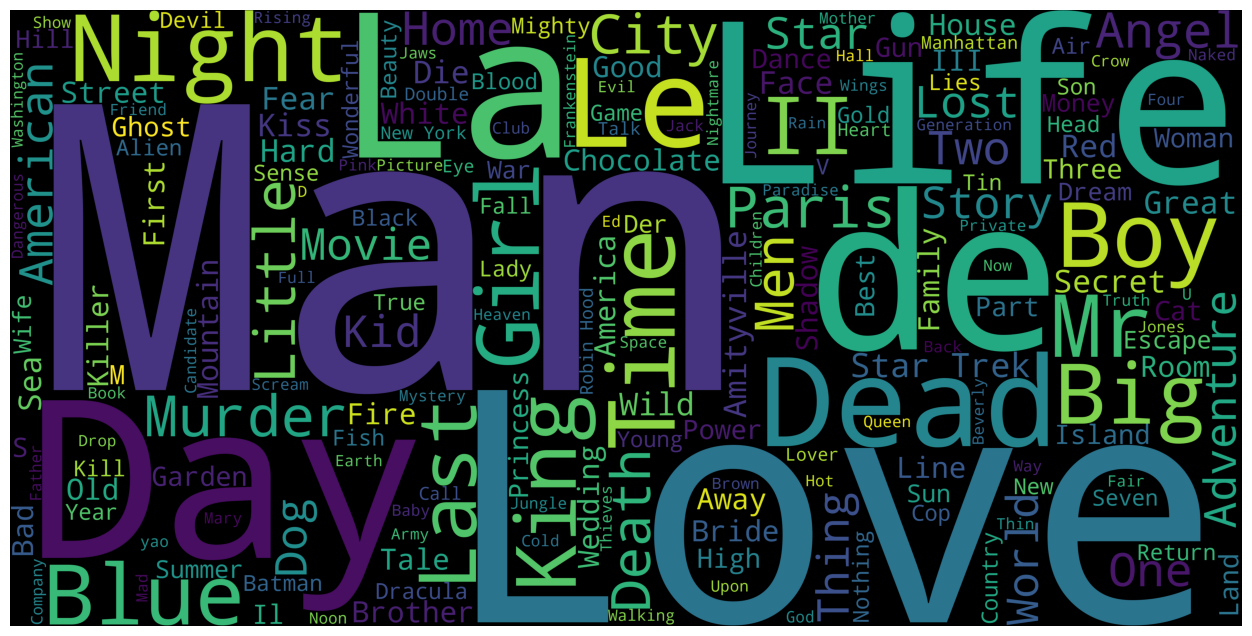

In [6]:
import wordcloud 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("")
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

# Building Graph for Community Dectection

- Bulding user-movie matrix
- Determine similarity by comparing the pairwise distances between user's rating (Euclidean distance calculation)
    - Need to normalize the user_movie rating to standardize form before compare the distance


<div class="alert alert-block alert-warning">
<b>Example of pairwise distance with user rating:</b>

- User 1 has rated movies 1 to 5 as [0, 1, 2, 5, 2].
- User 2 has rated movies 1 to 5 as [0, 1, 1, 4, 2]. <br>
Calculate the Euclidean distance between User 1 and User 2:

1. Subtract the ratings of User 2 from User 1 for each movie.
    - Differences for each movie: [0-0, 1-1, 2-1, 5-4, 2-2] = [0, 0, 1, 1, 0].
2. Square each of these differences: [0^2, 0^2, 1^2, 1^2, 0^2] = [0, 0, 1, 1, 0]
3. Sum up all the squared differences. 0 + 0 + 1 + 1 + 0 = 2
4. Square root of this sum: sqrt(2) <br>

Pairwise distance between user 1 and user 2: sqrt(2)
</div>


## User-Movie Rating Matrix

In [7]:
user_movie = user_ratings.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
user_movie.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalize the user_movie matrix and Calculate the distance matric between users

In [8]:
from scipy.spatial.distance import pdist, squareform
import numpy as np


""" 
    Purpose of Normalization: doesn't bias/affect the distance calculations. 
    standardizing user rating vectors, allowing for a more accurate comparison of user preferences.
    Similarity: Vectors point in the same direction, indicating similar movie preferences
    
"""

# Cal the magnitude of rating vector (Euclidean Norm) by the square root of the sum of the squares of the elements in ratings[i] with np.linalg.norm(ratings[i])
# Then divides each element in the user's rating vector by the magnitude. This is known as normalizing the vector
magnitude_ratings = user_movie.values
for i in range(magnitude_ratings.shape[0]):
    magnitude_ratings[i] /= np.linalg.norm(magnitude_ratings[i])

print(magnitude_ratings)
# OR
# from sklearn.metrics.pairwise import cosine_similarity
# magnitude_ratings = cosine_similarity(user_movie)  
# print(magnitude_ratings)



# Bulding the distance between users
distances = pdist(user_movie.values, metric='euclidean')
distance_matrix = squareform(distances)
# distance_matrix.shape
avg_distance = np.sum(distance_matrix) / (distance_matrix.shape[0] ** 2 - distance_matrix.shape[0])
print(avg_distance)
distance_matrix += np.eye(distance_matrix.shape[0]) * 99999

# Set threshold to 90% average distance
threshold = 0.9 * avg_distance  # 90% of average distance

[[0.07927525 0.04756515 0.0634202  ... 0.         0.         0.        ]
 [0.13201967 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.2575131  0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.106143   0.         ... 0.         0.         0.        ]]
1.2832457998257238


## Graph SNA 
> Nodes are users and connection will be distance of users with each other
>    - If pairwise distance <= average distance then there will be edge between users

Number of connected components: 40

Number of nodes:
904

Number of edges:
49305


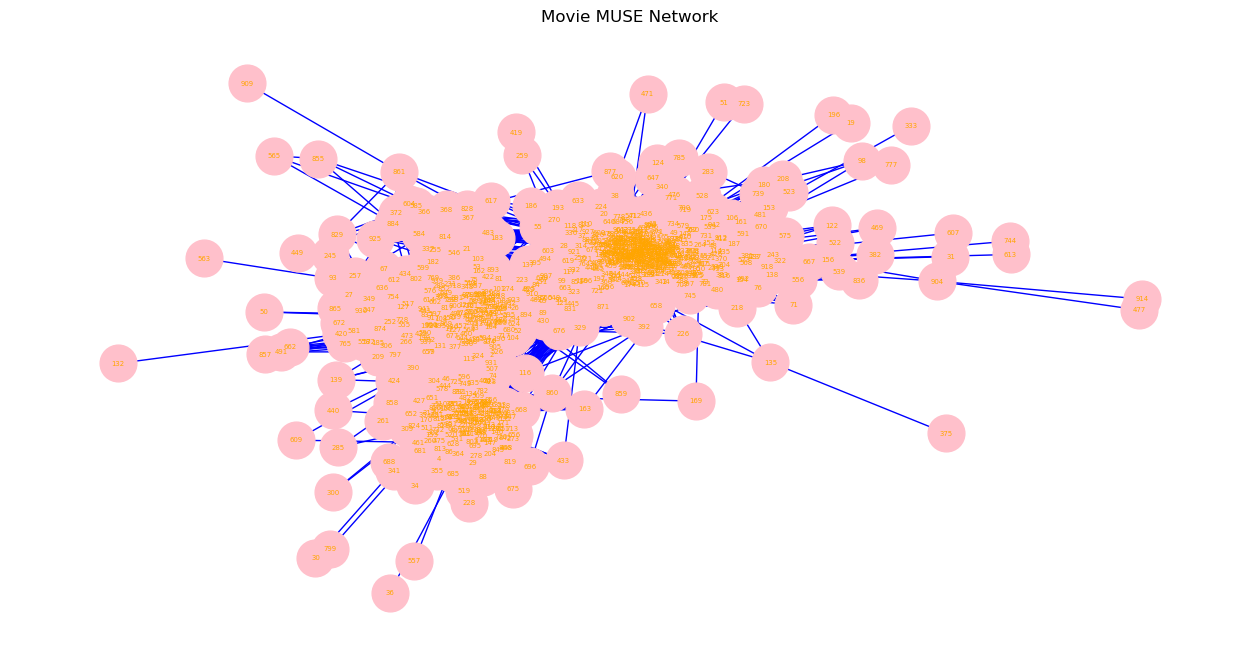

In [9]:
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt


# distances = pdist(user_movie.values, metric='euclidean')
# distance_matrix = squareform(distances)
# average_distance = np.mean(distances)
# print(average_distance)



G = nx.Graph()

# Add nodes for each user
for user in user_movie.index:
    G.add_node(user)

# Add edges based on the threshold
for i, user1 in enumerate(user_movie.index):
    for j, user2 in enumerate(user_movie.index):
        if i < j and distance_matrix[i, j] <= threshold:
            G.add_edge(user1, user2)

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
print("Number of connected components:", len(Gcc))
G = G.subgraph(Gcc[0])

print("\nNumber of nodes:")
print(G.number_of_nodes())

print("\nNumber of edges:")
print(G.number_of_edges())
plt.figure(figsize=(16, 8))
pos = nx.spring_layout(G)  # positions for all nodes

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='pink')

# Edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='blue')

# Labels
nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif', font_color="orange")
nx.write_gexf(G, "userconnection.gexf")
plt.title("Movie MUSE Network")
plt.axis('off')  # Turn off the axis
plt.show()

# Create Graph where nodes are users and edges are relationship base on personal propensity of users such as age, gender, occupation 
# G = nx.Graph()
# # Add nodes to each user
# G.add_nodes_from(users['user_id'].unique())
# relationship_table = pd.DataFrame(0, index=users['user_id'], columns=users['user_id'])


# # Add edges between users with same occupation and gender
# user_occupation = users['occupation'].unique()
# user_gender = ['M','F']
# for occupation in user_occupation:
#     for gender in user_gender:
#         # get subset of users with same occupation and gender
#         sub_df = users[(users['occupation'] == occupation) & (users['gender'] == gender)]
#         # create edge between all users in subset
#         for user1 in sub_df['user_id']:
#             for user2 in sub_df['user_id']:
#                 if user1 < user2: # If users have the same occupation and gender then there is connection between them. (edges without duplicates) 
#                     G.add_edge(user1, user2)
#                     # Debug: Print the connection if occupation is student and gender is Female
#                     if occupation == "student" and gender == "F":
#                         print(f"Edge added between User {user1} and User {user2} - Occupation: {occupation}, Gender: {gender}")

# # debug
# print("\nNumber of nodes:")
# print(G.number_of_nodes())

# print("\nNumber of edges:")
# print(G.number_of_edges())
                    


###  COMMUNITY DETECTION. 
- Applying the Louvain Method to identify communities based on modularity optimization. 
- It can provide significant insights into the structure and characteristics of the network
- Insight from graph: modulairy score can tell if the community is strong community or not

c:\Users\traml\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


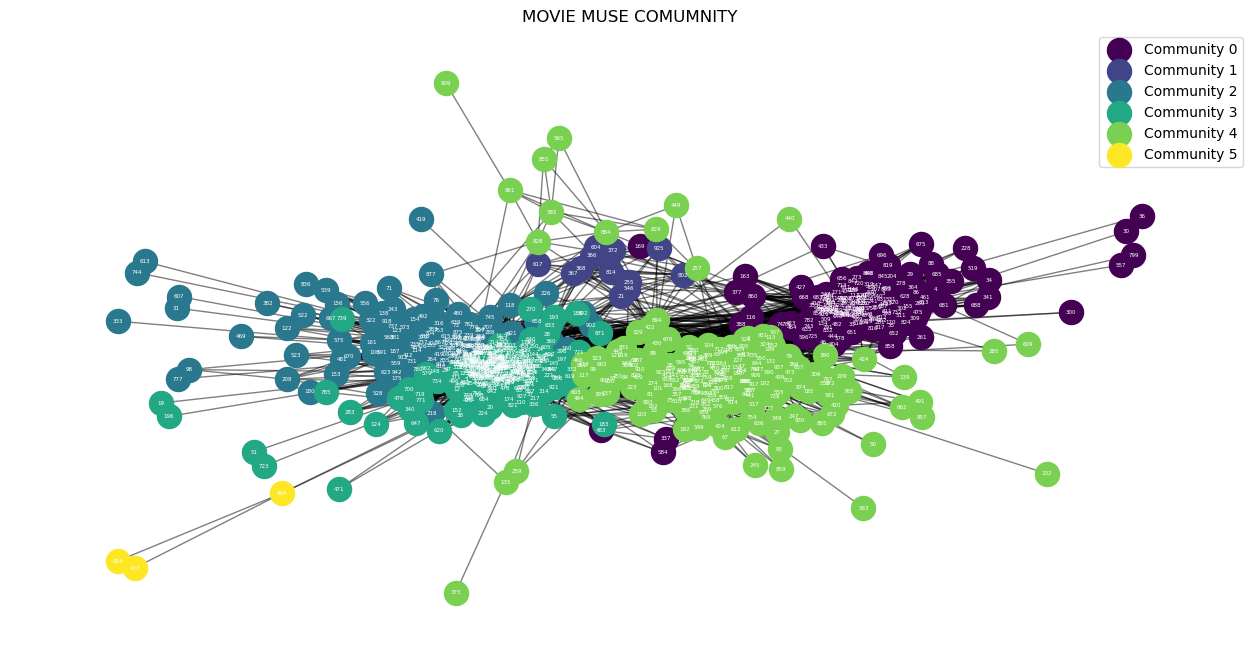

Modularity: 0.39
Number of communities detected: 6


In [10]:

communities = nx.community.louvain_communities(G)

modularity = nx.community.modularity(G, communities=communities)

# Function to draw the communities
def draw_communities(G, communities):
    plt.figure(figsize=(16, 8))
    # Use the spring layout for node positioning
    pos = nx.spring_layout(G)

    # Create a color map with a color for each community
    cmap = plt.cm.viridis
    community_colors = [cmap(i) for i in np.linspace(0, 1, len(communities))]

    # Draw the nodes, coloring them by community
    for i, community in enumerate(communities):
        node_list = list(community)
        node_color = community_colors[i]
        nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=node_color, label=f"Community {i}")

    # Draw the edges
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=4, font_color='white')
    
    # Show the legend
    plt.legend(scatterpoints=1)

    # Show the plot
    plt.title("MOVIE MUSE COMUMNITY")
    plt.axis('off')
    plt.show()



# Call the function to draw the communities
draw_communities(G, communities)
nx.write_gexf(G, "test.gexf")

print(f"Modularity: {modularity:.2f}")
print(f"Number of communities detected: {len(communities)}")


# Girvan-Newman method
# import itertools
# def draw_communities(G, communities):
#     cmap = plt.cm.get_cmap('viridis', max(len(c) for c in communities))
#     color_list = [cmap(i) for i in range(len(communities))]

#     node_color = []
#     for node in G.nodes():
#         for i, community in enumerate(communities):
#             if node in community:
#                 node_color.append(color_list[i])
#                 break

#     # Draw the graph
#     nx.draw(G, node_color=node_color, with_labels=True, edge_color='black')
    
# # Apply the Girvan-Newman algorithm to find the community structure
# comp = nx.community.girvan_newman(G)

# # Find the communities and modularity for each level of the algorithm
# k = 10
# modularities = []
# max_modularity = -1
# best_community = None

# for communities in itertools.islice(comp, k):
#     print("Communities at level:", len(modularities) + 2)
#     print(tuple(sorted(c) for c in communities))
#     modularity = nx.community.modularity(G, communities)
#     print("Modularity: {0:.2f}".format(modularity))
#     modularities.append(modularity)
#     if modularity > max_modularity:
#         max_modularity = modularity
#         best_community = communities

# # Draw the best community detection
# draw_communities(G, best_community)
# plt.title('Movie Best Community Based On Occupation and Gender')
# # Display the plot
# plt.show()

# # Plot the modularity as a function of the number of clusters
# plt.plot(range(2, k + 2), modularities)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Modularity')
# plt.xticks(range(2, k + 2))
# plt.show()



## Apply Cosine similarity 
- The cosine similarity function that automaticlly calculate the magnitude of vectors, focusing on their direction
- Determining the best matching community for a new user based on their personal information: gender and occupation and their favorite movie catergory
- Then add the new user to the community where they have the highest similarity score (highest cosine value)
 

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# To see user interactions to genres(movie catogery)
user_genre_rating = pd.merge(user_ratings, movies, on='movie_id').groupby('user_id')[movies.columns[6:]].max().reset_index()
# print(user_genre_rating)

# use get_dummies instead of usecol to encode the demographic data(0 and 1) because 'gender', 'occupation' not numeric data
users_encoded = pd.get_dummies(users, columns=['gender', 'occupation'])
# convert to binary: 1-0
users_encoded = users_encoded*1
# print(users_encoded)

# Merge with the genre interaction data
users_with_genres = pd.merge(users_encoded, user_genre_rating, on='user_id', how='left')
#print(users_with_genres)

# Tram      | F | student
# Jagr      | M | student
# P.Tsung   | M | teacher
# Erik      | M | student
# Pranavi   | F | student
# P.Zhu     | F | teacher
new_users = [{'gender': 'F', 'occupation': 'student','Comedy': 3,'Animation': 4,'Romance': 5, 'Sci-Fi': 3,'Drama': 5,'Horror': 3, 'War': 2},       
            {'gender': 'M', 'occupation': 'student', 'Adventure': 1,'Sci-Fi': 5, 'Mystery': 1,'Film-Noir': 5, 'Western': 4},             
            {'gender': 'M', 'occupation': 'educator', 'Action': 3,'Sci-Fi': 5, 'Documentary': 4, 'Adventure': 3, 'Thriller': 1},                          
            {'gender': 'M', 'occupation': 'student', 'Fantasy': 4,'Drama': 1, 'Mystery': 2,'Thriller': 5,'Comedy': 2, 'Crime': 4},                 
            {'gender': 'F', 'occupation': 'student', 'Romance': 1,'Musical': 3, 'Animation': 5,'Horror': 1,'Romance': 4, 'Sci-Fi': 3,'Action': 1}, 
            {'gender': 'F', 'occupation': 'educator', 'Musical': 5, 'Children': 4,'Comedy': 5, 'Drama': 3, 'War': 1}               
            ]
     

for new_user in new_users:  
    new_user_df = pd.DataFrame([new_user])
    new_user_encoded = pd.get_dummies(new_user_df)
    #convert to binary value
    new_user_encoded = new_user_encoded*1
    # print(new_user_encoded)

     # fill all other value of genre to 0
    new_user_aligned = new_user_encoded.reindex(columns=users_with_genres.columns, fill_value=0)
    
     # combine the existing data with the new user data
    combined_data = pd.concat([users_with_genres, new_user_aligned], ignore_index=True)
    combined_data = combined_data.drop(['zipcode'], axis=1)
    print(combined_data)


    """
    Compute cosine similarity:
    A score close to 1 indicates a high degree of similarity.
    A score close to 0 indicates little or no similarity.
    A score close to -1 indicate opposite preferences.

    """
    similarity_matrix = cosine_similarity(combined_data) # use sonsine to compute similary between each pair of users (row)
    # print(similarity_matrix)
    
    # Similarity of the new user which is last row [-1:] to further down in matrix except the last row [:-1](avoid compare by itself)
    new_user_similarity = similarity_matrix[-1, :-1]  
    #print(f"Similarity scores of new user {new_user} with all others: {new_user_similarity}")

    # Determine the most similar community to new user
    community_similarity = {}
    max_score = {}
    for i, community in enumerate(communities):
        # Get postion of users in the community
        user_in_community = [i for i, user in enumerate(users['user_id']) if user in community]
        # Calculate average similarity of the new user to this community
        community_similarity[i] = new_user_similarity[user_in_community].mean()
        #print(f"Average similarity of new user with community {i:.2f}: {community_similarity}")

        # Debug
        max_score[i] = max(new_user_similarity[user_in_community])

    if max_score:
        # Find the community with the highest average similarity
        newuser_best_community = max(max_score, key=max_score.get)
        max_similarity_score = max_score[newuser_best_community]

        # Modify Community Structure
        # Add the new user to the decteted community (assuming communities are sets and new user ID is next int)
        communities[newuser_best_community].add(max(users['user_id'])) 
        
        # print(f"New user {new_user} added to community {newuser_best_community} with highest similarity score: {max_similarity_score:.2f}")
        print(f"New user {new_user} added to community {newuser_best_community}")
    else:
        print("No community found for new user", new_user)




     user_id  age  gender_F  gender_M  occupation_administrator  \
0          1   24         0         1                         0   
1          2   53         1         0                         0   
2          3   23         0         1                         0   
3          4   24         0         1                         0   
4          5   33         1         0                         0   
..       ...  ...       ...       ...                       ...   
939      940   32         0         1                         1   
940      941   20         0         1                         0   
941      942   48         1         0                         0   
942      943   22         0         1                         0   
943        0    0         1         0                         0   

     occupation_artist  occupation_doctor  occupation_educator  \
0                    0                  0                    0   
1                    0                  0                    0 

## Ranking the popularity/highly-rated movies within a user in each commnity and recommend top movies to the new user in that community 

In [12]:
# define communities of new user
# new_user_communities = [0,1,2,3,4,5]
new_user_communities = [2,3]

for users_group in new_user_communities:
    # Filter ratings for users in the best community
    best_community = communities[users_group]
    community_ratings = user_ratings[user_ratings['user_id'].isin(best_community)]

    # Rank movies by their average rating within the community
    movie_popularity = community_ratings.groupby('movie_id')['rating'].mean()

    # Round ratings to one decimal
    movie_popularity = movie_popularity.round(1)
    
    # Take only movie have rating over 4
    movie_ratings = movie_popularity[movie_popularity >= 4].reset_index()

    # Merge with the movies DataFrame to get movie titles
    top_rated_movies = movie_ratings.merge(movies, on='movie_id')

    # Get the top 10 movies' titles
    genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                     'Thriller', 'War', 'Western']

    #top_10_movies = top_rated_movies[['title','rating'] + genre_columns].head(50)
    #top_10_movies = top_rated_movies[['title','rating'] + genre_columns].head(20)
    top_10_movies = top_rated_movies[['title','rating'] + genre_columns].head(5)

    print(f"\nTop 5 movies in the community {users_group} :")
    print("\tTitle" + "\t\t\tRating" + "\t\t\t\tCategory")
    for index, row in top_10_movies.iterrows():
        genres = []
        for i in genre_columns:
            #Get the genres for each movie where the value is 1
            if row[i] == 1:
                genres.append(i)
        genres_str = ', '.join(genres)
        
        # Print movie title, rating, and genres
        print(f"{row['title']:<33} {row['rating']:<25} {genres_str}")
    print("\n" + "=========================================================================" + "\n")


Top 5 movies in the community 2 :
	Title			Rating				Category
Babe (1995)                       4.0                       Comedy, Crime, Fantasy
Dead Man Walking (1995)           4.2                       Fantasy
Richard III (1995)                4.2                       Fantasy, Western
Usual Suspects, The (1995)        4.4                       Documentary, War
Postino, Il (1994)                4.1                       Fantasy, Sci-Fi



Top 5 movies in the community 3 :
	Title			Rating				Category
Toy Story (1995)                  4.0                       Children, Comedy, Crime
Babe (1995)                       4.0                       Comedy, Crime, Fantasy
Seven (Se7en) (1995)              4.0                       Documentary, War
Usual Suspects, The (1995)        4.4                       Documentary, War
White Balloon, The (1995)         4.0                       Fantasy


